In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# 忽略所有UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

In [21]:
# 导入必要的库
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 特征处理和转换
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [22]:
# 设置绘图风格

%matplotlib inline
# 在 Jupyter Notebook 中自动显示生成的图表（而不是弹出窗口）。
# 功能：这是 Jupyter Notebook 的魔法命令（magic command），
#       用于将 matplotlib 生成的图表直接嵌入到 Notebook 的单元格中显示。
# 说明：如果不使用此命令，在 Notebook 中运行绘图代码后可能不会显示图表。
#       使用 %matplotlib inline 后，图表会以静态图片的形式直接显示在输出区域。

# 使用 seaborn 设置美观的默认样式（白色背景 + 网格线 + 柔和色调），使图表更清晰、易读。
sns.set(style='whitegrid', palette='muted')
# 功能：这是 seaborn 库的样式设置方法，用于调整图表的整体视觉风格。
# 参数解释：
#   style='whitegrid'：设置图表背景为白色，并添加灰色网格线。
#       这种风格适合大多数数据可视化场景，能够提高图表的可读性。
#   palette='muted'：设置默认的颜色调色板为柔和的配色方案。
#       'muted' 调色板中的颜色更加温和，避免过于刺眼，适合展示在 PPT 或报告中。
# 效果：所有后续用 matplotlib 和 seaborn 绘制的图表都会采用这种风格和配色方案。


### 读取数据

In [23]:
# 读取训练数据和测试数据
train_data = pd.read_csv('../train.csv')
test_data = pd.read_csv('../test2.csv')

### 分析数据得到数据集的基本信息
* 训练集和测试集，没有缺失值
* 训练集 1100行，31列
* 测试集 350行，31列
* Over18 变量的值都是Y，可以删除
* StandardHours 变量的值都是80，可以删除
* EmployeeNumber 是员工编号，通常是唯一标识每个员工的ID。可以删除

### 删除无用特征

In [24]:
# 删除Over18变量
train_data = train_data.drop(['Over18','StandardHours','EmployeeNumber'], axis=1)
test_data = test_data.drop(['Over18','StandardHours','EmployeeNumber'], axis=1)

In [25]:
X_train = train_data.drop('Attrition', axis=1)
X_test = test_data.drop('Attrition', axis=1)
y_train = train_data['Attrition']
y_test = test_data['Attrition']

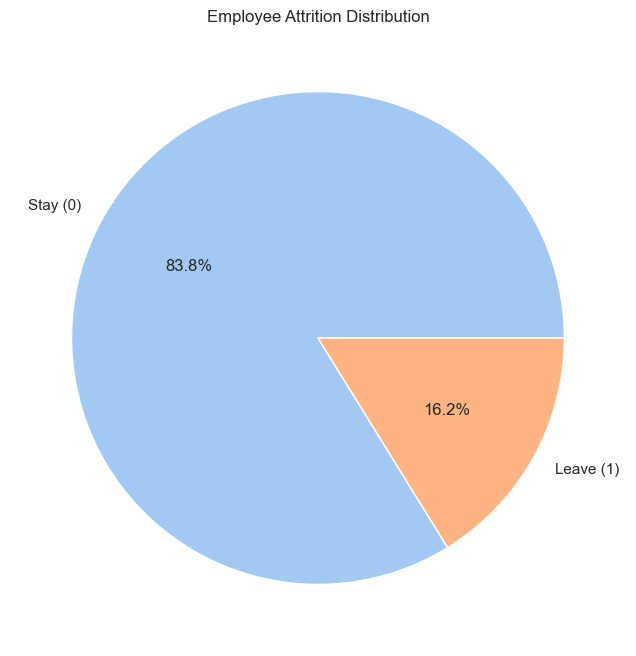

In [26]:
# 饼图
plt.figure(figsize=(8, 8))
plt.pie([922, 178],     # 922 / 178 + 922 = 922 / 1100 = 83.8 %
        labels=['Stay (0)', 'Leave (1)'],       # 922 占比为 Stay (0) 标签
        autopct='%1.1f%%',      # 取小数点后一位
        colors=sns.color_palette('pastel'))

plt.title('Employee Attrition Distribution')
plt.show()

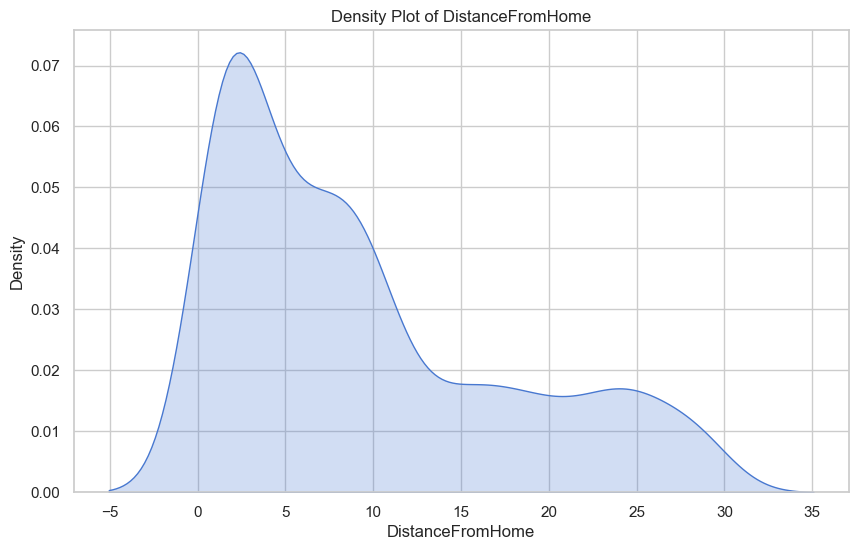

In [32]:
import seaborn as sns
# 绘制密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(X_train['DistanceFromHome'], fill=True)
plt.title('Density Plot of DistanceFromHome')
plt.xlabel('DistanceFromHome')
plt.show()


### 类别特征编码 以及 检测和处理偏态分布

In [33]:
from sklearn.preprocessing import OneHotEncoder
# 1. 类别特征编码
def fit_transform_features(df):
    # 1. 类别特征编码
    def encode_categorical(df):
        # 无序特征用独热编码
        nominal_features = ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime']
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        # 新版本的写法
        encoded = encoder.fit_transform(df[nominal_features])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(nominal_features), index=df.index)
        df = df.drop(nominal_features, axis=1)
        df = pd.concat([df, encoded_df], axis=1)
        return df, encoder

    # 2. 检测和处理偏态分布
    def handle_skewness(df):
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        skewed_features = []
        for col in numeric_cols:
            skewness = df[col].skew()
            if abs(skewness) > 0.5:  # 设定偏态阈值
                df[col] = np.log1p(df[col])
                skewed_features.append(col)
        print(f"进行对数变换的特征: {skewed_features}")
        return df, skewed_features

    # 编码类别特征
    df, encoder = encode_categorical(df)
    # 处理偏态分布
    df, skewed_features = handle_skewness(df)
    return df, encoder, skewed_features

def transform_features(df, encoder, skewed_features):
    # 编码类别特征
    nominal_features = \
        ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime']
    encoded = encoder.transform(df[nominal_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(nominal_features), index=df.index)
    df = df.drop(nominal_features, axis=1)
    df = pd.concat([df, encoded_df], axis=1)
    # 处理偏态分布
    for col in skewed_features:
        df[col] = np.log1p(df[col])
    return df


### 标准化

In [34]:
def fit_scale_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df, scaler, numeric_cols

def scale_features(df, scaler, numeric_cols):
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    return df


### 处理样本不均

In [35]:
def handle_imbalance(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

### 特征选择

In [36]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def select_features_cv(X, y, step=1, cv=5):
    estimator = LogisticRegression(max_iter=1000, random_state=42)
    rfecv = RFECV(
        estimator=estimator,
        step=step,
        cv=StratifiedKFold(cv),
        scoring='accuracy',
        n_jobs=-1
    )
    X_selected = rfecv.fit_transform(X, y)
    print(X_selected)
    selected_features = X.columns[rfecv.support_]
    return X_selected, selected_features, rfecv


### 训练集和数据集各自分别进行处理

In [37]:
# 在训练集上进行特征转换
# 1. 特征编码和处理偏态分布
X_train, encoder, skewed_features = fit_transform_features(X_train)

# 2. 标准化数值特征
X_train, scaler, numeric_cols = fit_scale_features(X_train)

# 3. 处理类别不平衡（SMOTE）
X_train_balanced, y_train_balanced = handle_imbalance(X_train, y_train)

# 4. 特征选择
X_train_selected, selected_features, rfecv = select_features_cv(X_train_balanced, y_train_balanced)

# 在测试集上应用相同的转换
# 1. 特征编码和处理偏态分布
X_test = transform_features(X_test, encoder, skewed_features)

# 2. 标准化数值特征
X_test = scale_features(X_test, scaler, numeric_cols)

# 3. 特征选择
X_test_selected = X_test[selected_features]

进行对数变换的特征: ['DistanceFromHome', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'MaritalStatus_Divorced', 'MaritalStatus_Single', 'OverTime_No', 'OverTime_Yes']
[

### 使用逻辑回归进行预测
* AUC Score: 0.8797

In [42]:
from sklearn.linear_model import LogisticRegression

# 初始化逻辑回归模型
model = LogisticRegression(max_iter=1000, random_state=42)

# 在训练集上训练模型
model.fit(X_train_selected, y_train_balanced)

# 使用训练好的模型在测试集上进行预测
y_pred = model.predict(X_test_selected)

# 导入评估指标
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 打印分类报告
print(classification_report(y_test, y_pred))

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("混淆矩阵：\n", cm)

# 如果需要，计算 ROC AUC 分数
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


              precision    recall  f1-score   support

           0       0.96      0.79      0.87       297
           1       0.41      0.79      0.54        53

    accuracy                           0.79       350
   macro avg       0.68      0.79      0.70       350
weighted avg       0.87      0.79      0.82       350

混淆矩阵：
 [[236  61]
 [ 11  42]]
ROC AUC Score: 0.8797


### 使用xgboost进行预测
* AUC Score: 0.8459

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 初始化 XGBoost 模型
model = XGBClassifier(
    n_estimators=100,        # 树的数量
    learning_rate=0.1,       # 学习率
    max_depth=6,             # 树的最大深度
    random_state=42,         # 随机种子
    use_label_encoder=False, # 新版本中不需要 label encoder
    eval_metric='logloss'    # 评估指标
)

# 在训练集上训练模型
model.fit(X_train_selected, y_train_balanced)

# 使用训练好的模型在测试集上进行预测
y_pred = model.predict(X_test_selected)

# 打印分类报告
print(classification_report(y_test, y_pred))

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("混淆矩阵：\n", cm)

# 计算 ROC AUC 分数
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


              precision    recall  f1-score   support

           0       0.90      0.96      0.93       297
           1       0.65      0.42      0.51        53

    accuracy                           0.88       350
   macro avg       0.77      0.69      0.72       350
weighted avg       0.86      0.88      0.87       350

混淆矩阵：
 [[285  12]
 [ 31  22]]
ROC AUC Score: 0.8459


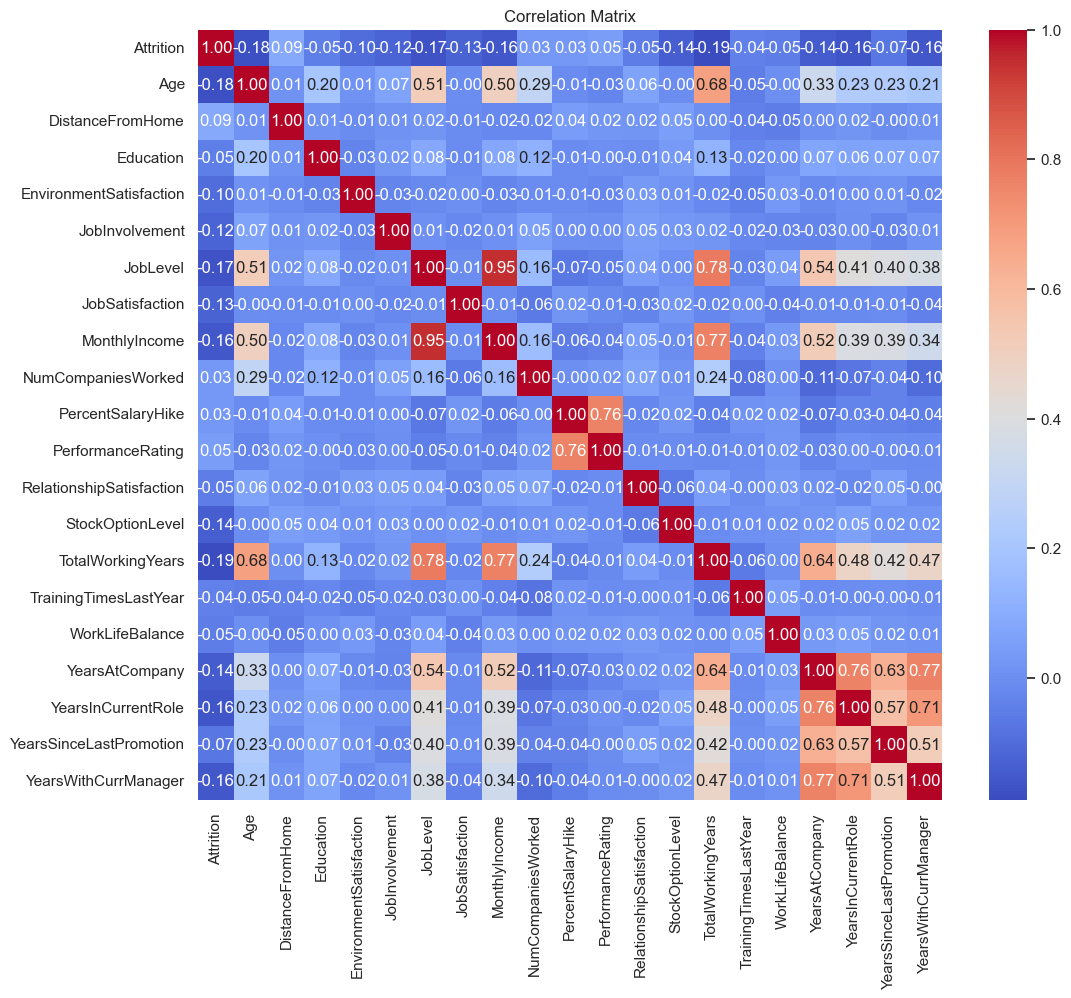

In [48]:
# 数值型变量的分布
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_data[numerical_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()